In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Denoising MNIST

In [2]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

data = data[:, 1:]

data_norm = data / np.max(data)

data_tensor = torch.FloatTensor(data_norm)

In [3]:
def create_autoencoders():
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 250)
            self.enc = nn.Linear(250, 50)
            self.code = nn.Linear(50, 250)
            self.dec = nn.Linear(250, 784)
            
        def forward(self, x):
            x = f.relu(self.input(x))
            x = f.relu(self.enc(x))
            x = f.relu(self.code(x))
            return torch.sigmoid(self.dec(x))
    
    model = Model()
    
    loss_fun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    
    return model, loss_fun, optimizer

In [4]:
def train_model():
    num_epochs = 10000

    model, loss_fun, optimizer = create_autoencoders()
    
    losses = torch.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        
        random_index = np.random.choice(data_tensor.shape[0], size=32)
        
        x = data_tensor[random_index, :]
        
        y_hat = model(x)
        
        loss = loss_fun(y_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses[epoch] = loss.item()
        
    return losses, model

Final Loss: 0.01


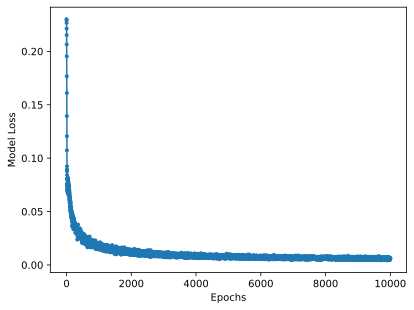

In [5]:
losses, model = train_model()
print(f"Final Loss: {losses[-1]:0.2f}")

plt.plot(losses, '.-')
plt.xlabel("Epochs")
plt.ylabel("Model Loss");

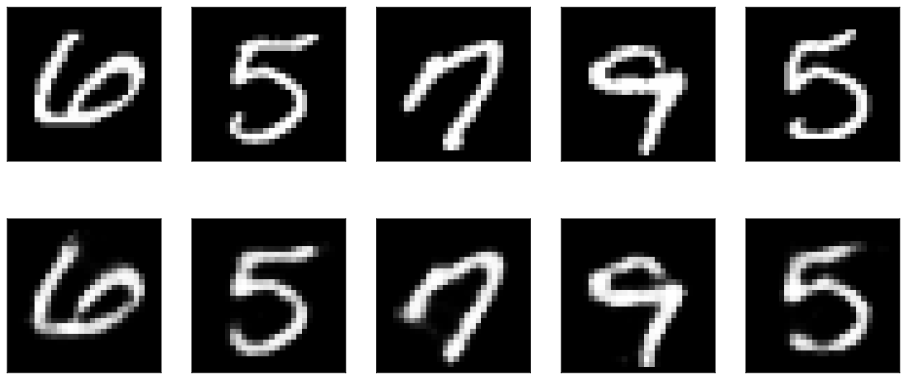

In [6]:
x = data_tensor[:5, :]
y_hat = model(x)

_, axis = plt.subplots(2, 5, figsize=(16, 7))

for i in range(5):
    axis[0, i].imshow(x[i, :].view(28, 28).detach(), cmap="gray")
    axis[1, i].imshow(y_hat[i, :].view(28, 28).detach(), cmap="gray")
    
    axis[0, i].set_xticks([]), axis[0, i].set_yticks([])
    axis[1, i].set_xticks([]), axis[1, i].set_yticks([])

plt.show()

# Adding the noise to the data to check

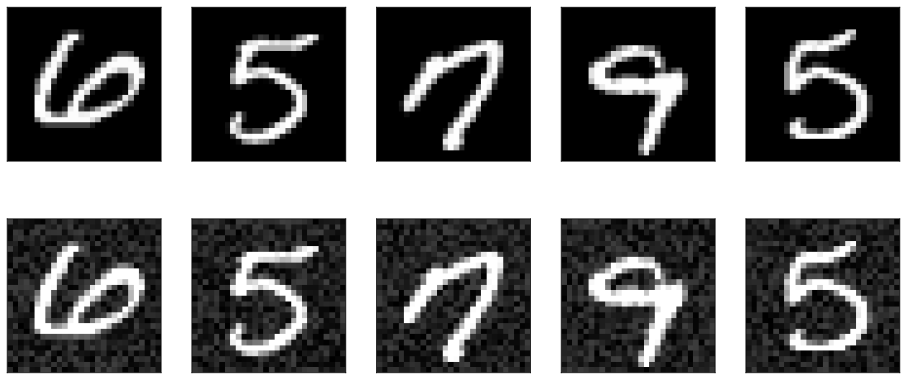

In [7]:
x = data_tensor[:10, :]

x_noise = x + torch.rand_like(x)/4

x_noise[x_noise>1] = 1

_, axis = plt.subplots(2, 5, figsize=(16, 7))

for i in range(5):
    axis[0, i].imshow(x[i, :].view(28, 28).detach(), cmap="gray")
    axis[1, i].imshow(x_noise[i, :].view(28, 28).detach(), cmap="gray")

    axis[0, i].set_xticks([]), axis[0, i].set_yticks([])
    axis[1, i].set_xticks([]), axis[1, i].set_yticks([])

plt.show()

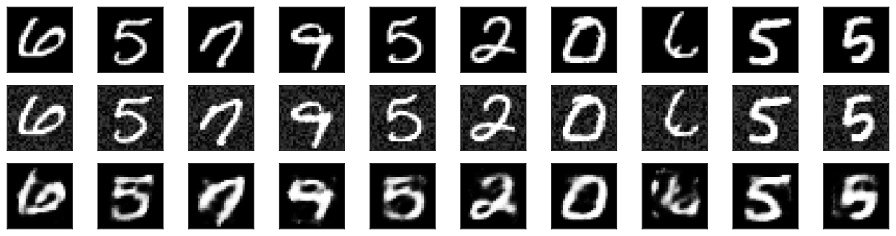

In [8]:
y_hat = model(x_noise)

_, axis = plt.subplots(3, 10, figsize=(16, 4))

for i in range(10):
    axis[0, i].imshow(x[i, :].view(28, 28).detach(), cmap="gray")
    axis[1, i].imshow(x_noise[i, :].view(28, 28).detach(), cmap="gray")
    axis[2, i].imshow(y_hat[i, :].view(28, 28).detach(), cmap="gray")

    axis[0, i].set_xticks([]), axis[0, i].set_yticks([])
    axis[1, i].set_xticks([]), axis[1, i].set_yticks([])
    axis[2, i].set_xticks([]), axis[2, i].set_yticks([])

plt.show()

# Experiments on the Units with the Denoising that which will perform better

In [9]:
def exp_create_autoencoders(enc_unit, bottleneck_unit):

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, enc_unit)
            self.enc = nn.Linear(enc_unit, bottleneck_unit)
            self.code = nn.Linear(bottleneck_unit, enc_unit)
            self.dec = nn.Linear(enc_unit, 784)

        def forward(self, x):
            x = f.relu(self.input(x))
            x = f.relu(self.enc(x))
            x = f.relu(self.code(x))
            return torch.sigmoid(self.dec(x))

    model = Model()

    loss_fun = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    return model, loss_fun, optimizer

In [10]:
def exp_train_model(enc_unit, bottleneck_unit):
    num_epochs = 10000

    model, loss_fun, optimizer = exp_create_autoencoders(enc_unit, bottleneck_unit)
    model.to(device)

    losses = []

    for epoch in range(num_epochs):

        random_index = np.random.choice(data_tensor.shape[0], size=32)

        x = data_tensor[random_index, :]
        x = x.to(device)

        y_hat = model(x)

        loss = loss_fun(y_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return losses, model

In [11]:
import sys
encoding_units = np.linspace(10, 500, 12)
bottleneck_units = np.linspace(5, 100, 8)
start = 0
total_models = 12*8
model_losses = np.zeros((len(encoding_units), len(bottleneck_units)))

for i, encoding_unit in enumerate(encoding_units):
    for j, bottleneck_unit in enumerate(bottleneck_units):
        losses, _ = exp_train_model(int(encoding_unit), int(bottleneck_unit))
        model_losses[i, j] = np.mean(losses[-3:])
        start += 1
        sys.stdout.write("\r" + f"Finished Running: {start}/{total_models}")

Finished Running: 96/96

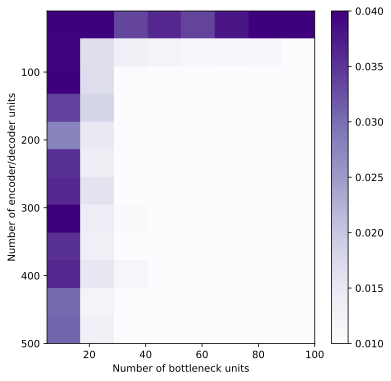

In [12]:
fig = plt.figure(figsize=(6,6))

plt.imshow(model_losses,aspect='auto', vmin=.01,vmax=.04, cmap='Purples', extent=(bottleneck_units[0],bottleneck_units[-1],encoding_units[-1],encoding_units[0]))

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar();

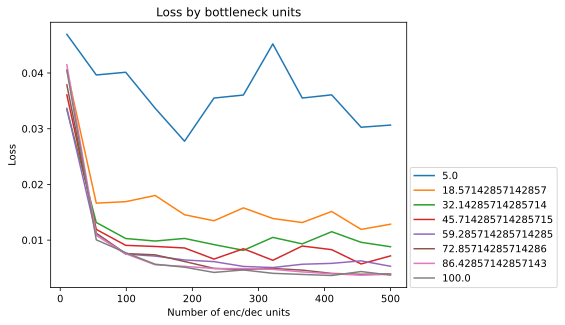

In [13]:
plt.plot(encoding_units,model_losses)
plt.legend(bottleneck_units,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss');